# Using a pretrained network to train the model
## Instantiating the VGG16 convolutional base

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


You pass three arguments to the constructor:
* `weights` specifies the weight checkpoint from which to initialize the model.
* `include_top` refers to including (or not) the densely connected classifier on top of the networ
* `input_shape` is the shape of the image tensors that you’ll feed to the network

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


## FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/My Drive/datasets/dog_vs_cat/small_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))

    # this gets the dir of the train image and 
    # convert it to binary and also resize all images to 150x150
    generator = datagen.flow_from_directory( directory,
                target_size=(150, 150),
                batch_size=batch_size,
                class_mode='binary')
    i = 0

    # Note the generator yields data indefinitely in a loop,
    # it must be stopped after every imeage has been since once
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


# The extracted features are currently of shape (samples, 4, 4, 512). 
# You’ll feed them to a densely connected classifier, 
# so first you must flatten them to (samples, 8192)
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Defining and training the densely connected classifier
At this point, you can define your densely connected classifier (note the use of drop-out for regularization) and train it on the data and labels that you just recorded

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))


model.save(base_dir + '/cats_and_dogs_small_pretrained_1.h5')

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.6505 - acc: 0.6310 - val_loss: 0.4513 - val_acc: 0.8240
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4380 - acc: 0.7930 - val_loss: 0.3625 - val_acc: 0.8590
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3717 - acc: 0.8335 - val_loss: 0.3195 - val_acc: 0.8840
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3200 - acc: 0.8695 - val_loss: 0.2957 - val_acc: 0.8890
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2864 - acc: 0.8855 - val_loss: 0.2813 - val_acc: 0.8920
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2680 - acc: 0.8940 - val_loss: 0.2854 - val_acc: 0.8860
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2452 - acc: 0.9085 - val_loss: 0.2639 - val_acc: 0.8940
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

## Plotting the results
The plot indicates that overfitting starts almost from the start, despite using dropout with a fairly large rate. This happen because this technique doesn't use data augmentation, which is essential to prevent overfitting

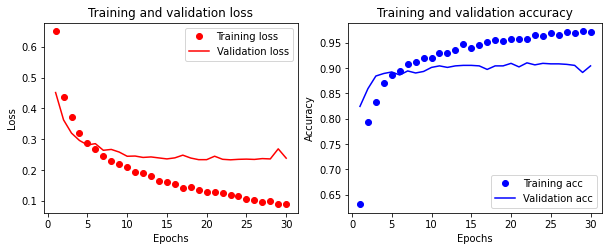

In [ ]:
def plot_history(history):
    import pandas as pd
    import matplotlib.pyplot as plt
    history_dict = history.history
    df = pd.DataFrame(history_dict)

    plt.rcParams['figure.figsize'] = [10, 3.5]
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    p1, p2 = axs[0], axs[1]

    epochs = range(1, len(df.index) + 1)
    p1.plot(epochs, df[df.columns[0]], 'ro', label='Training loss')
    p1.plot(epochs, df[df.columns[2]], 'r', label='Validation loss')
    p1.set_title('Training and validation loss')
    p1.set_xlabel('Epochs')
    p1.set_ylabel('Loss')
    p1.legend()

    p2.plot(epochs, df[df.columns[1]], 'bo', label='Training acc')
    p2.plot(epochs, df[df.columns[3]], 'b', label='Validation acc')
    p2.set_title('Training and validation accuracy')
    p2.set_xlabel('Epochs')
    p2.set_ylabel('Accuracy')
    p2.legend()

    plt.show()

plot_history(history)

## FEATURE EXTRACTION WITH DATA AUGMENTATION
Adding a densely connected classifier on top of the convolutional base

Before you compile and train the model, it’s very important to freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updating during training. If this is not done, the representations that were previously learned by the convolutional base will be modified during training

In [ ]:
import os
import numpy as np
from keras import models
from keras import layers
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/My Drive/datasets/dog_vs_cat/small_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False


## Training the model end to end with a frozen convolutional base

In [ ]:


from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')

# Validation set should not be argumented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                train_dir,                  # target directory
                target_size=(150, 150),     # resize image to 150 x 150
                batch_size=20,
                class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                validation_dir,
                target_size=(150, 150),
                batch_size=20,
                class_mode='binary')

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=2e-5),
            metrics=['acc'])

history = model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=50)

model.save(base_dir + '/dog_vs_cat_pretrained_2.h5')

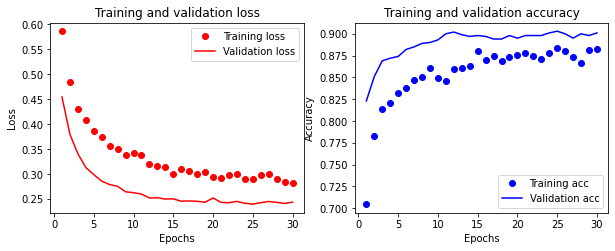

In [ ]:
plot_history(history)

In [1]:
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np

filepath = "/home/dit/DiT/GitHub/Pylingo/Jupyters/DS/Keras/dog_vs_cat_image_classification/web_demo/cats_and_dogs_small_pretrained_2.h5"

model = load_model(
    filepath,
    custom_objects=None,
    compile=True)

In [ ]:
# Model evaluation on the test data

In [10]:
from keras.preprocessing.image import ImageDataGenerator


test_path = '/content/drive/My Drive/datasets/dog_vs_cat/small_dataset/test'
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(
                test_path,
                target_size=(150, 150),
                batch_size=1,
                class_mode='binary')

strongly_wrong_idx = []
strongly_right_idx = []
weakly_wrong_idx = []


for i in range(test_set.__len__()):
    img = test_set.__getitem__(i)[0]
    pred_prob = model.predict(img)[0][0]
    pred_label = int(pred_prob > 0.5)
    actual_label = int(test_set.__getitem__(i)[1][0])

    if pred_label != actual_label and (pred_prob > 0.8 or
        pred_prob < 0.2): strongly_wrong_idx.append(i)
    elif pred_label != actual_label and (pred_prob > 0.4 and
        pred_prob < 0.6): weakly_wrong_idx.append(i)
    elif pred_label == actual_label and (pred_prob > 0.8 or
        pred_prob < 0.2): strongly_right_idx.append(i)

    # stop once we have enough images to plot
    if (len(strongly_wrong_idx)>=9 and len(strongly_right_idx)>=9
    and len(weakly_wrong_idx)>=9): break

print('done')

Found 1000 images belonging to 2 classes.


In [11]:
from matplotlib import pyplot as plt
import random

def plot_on_grid(test_set, idx_to_plot, img_size=150):
  fig, ax = plt.subplots(3,3, figsize=(20,10))
  for i, idx in enumerate(random.sample(idx_to_plot,9)):
    img = test_set.__getitem__(idx)[0].reshape(img_size, img_size ,3)
    ax[int(i/3), i%3].imshow(img)
    ax[int(i/3), i%3].axis('off')

## plot strongly predicted right
No surprises there! These are almost classical images of cats and dogs. Notice that the pointy ears of cats and the dark eyes of dogs can all be seen in the preceding images. These characteristic features allow our CNN to easily identify them.

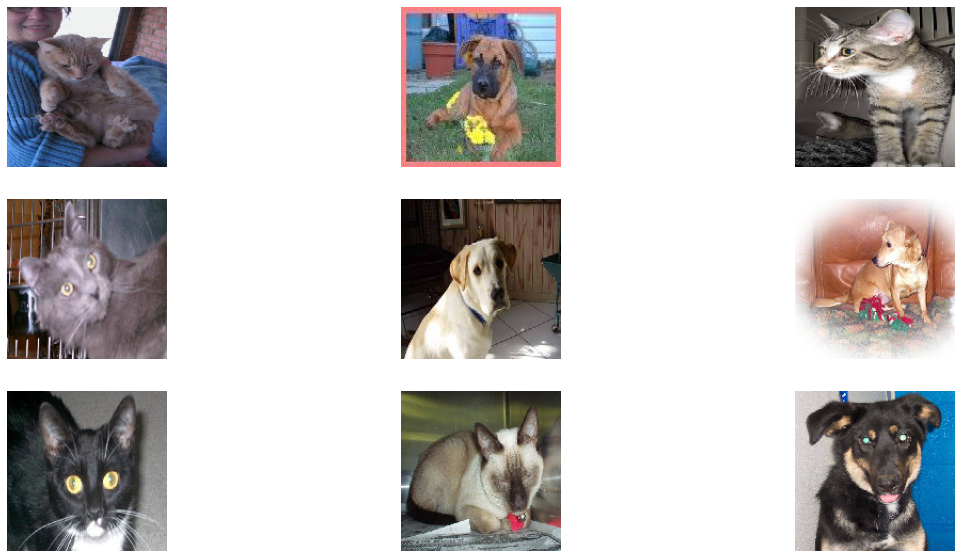

In [12]:
plot_on_grid(test_set, strongly_right_idx)

## plot strongly predicted wrong
We notice a few commonalities among these strongly wrong predictions. The first thing we notice is that certain dogs do resemble cats with their pointy ears. Perhaps our neural network placed too much emphasis on the pointy ears and classified these dogs as cats. Another thing we notice is that some of the subjects were not facing the camera, making it really difficult to identify them. No wonder our neural network got them wrong.

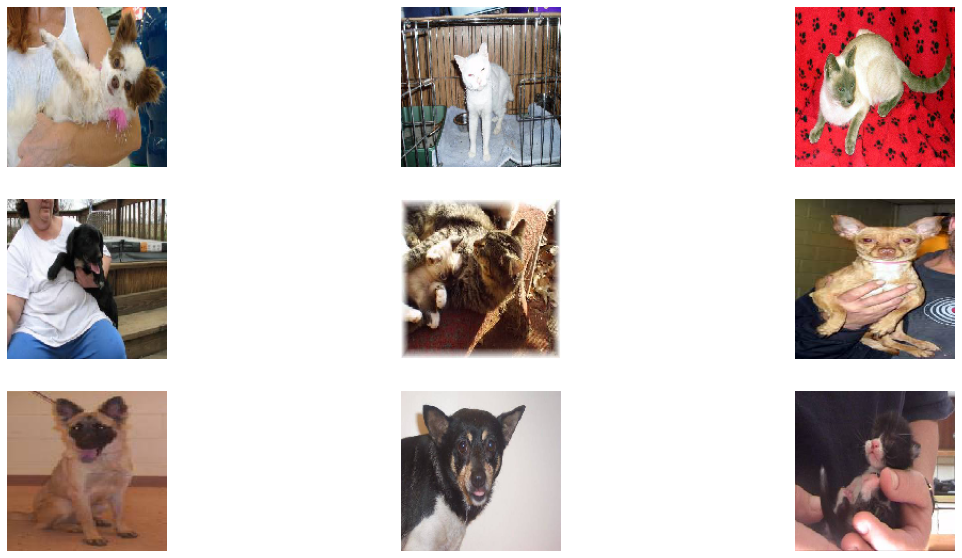

In [13]:
plot_on_grid(test_set, strongly_wrong_idx)

## plot weakly predicted wrong
These images are ones that our model is on the fence with. Perhaps there is an equal number of characteristics to suggest that the object could be a dog or a cat. This is perhaps the most obvious with the images in the first row, where the puppies in the first row have a small frame like a cat, which could have confused the neural network

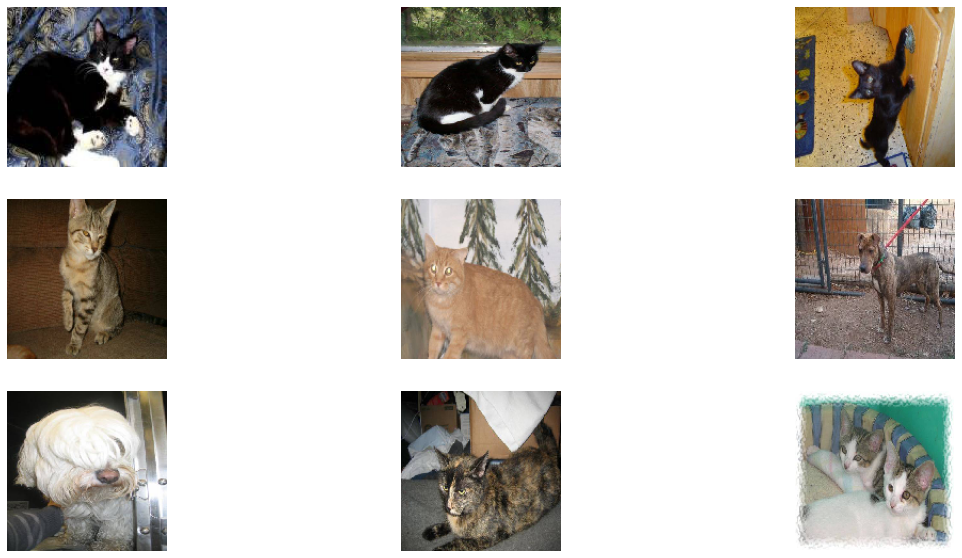

In [15]:
plot_on_grid(test_set, weakly_wrong_idx)

## Fine turning
It is another widely used technique for model reuse. Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model

### Steps for fine-tuning a network are as follow:
* Add your custom network on top of an already-trained base network.
* Freeze the base network.
* Train the part you added.
* Unfreeze some layers in the base network.
* Jointly train both these layers and the part you added.

In [ ]:
import os
import numpy as np
from keras import models
from keras import layers
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/My Drive/datasets/dog_vs_cat/small_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


## Freezing all layers up to a specific one
You’ll fine-tune the last three convolutional layers, which means all layers up to `block4_pool` should be frozen, and the layers `block5_conv1 , block5_conv2`, and `block5_conv3` should be trainable

In [ ]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

## Fine-tuning the model

Now you can begin fine-tuning the network. You’ll do this with the RMSP rop optimizer, using a very low learning rate. The reason for using a low learning rate is that you want to limit the magnitude of the modifications you make to the representations of the three layers you’re fine-tuning. Updates that are too large may harm these representations.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=50)

In [ ]:
plot_history(history)

## Smoothing the plots
 
These curves look noisy. To make them more readable, you can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities.

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_poin ts.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Inspecting and monitoring deep-learning models using Keras callbacks and TensorBoard

## Keras callbacks
Keras callbacks are used to monitor models while training. Some example of callbacks includes:
* `Model checkpointing`—Saving the current weights of the model at different points during training.
* `Early stopping`—Interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training).
* `Dynamically adjusting the value of certain parameters during training`—Such as the learning rate of the optimizer.
* `Logging training and validation metrics during training, or visualizing the representations learned by the model as they’re updated`—The Keras progress bar that you’re familiar with is a callback

## THE MODEL CHECKPOINT AND EARLYSTOPPING CALLBACKS
`EarlyStopping` can be used to interrupt traaining once a target metric being monitored stops mproving for a fixed number of epochs, i.e it can interrupt the model once overfitting starts. This helps to avoid use a smaller number of epochs.

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks_list = [EarlyStopping(                # interrupts training when improvement stops
                        monitor='acc',          # Monitors the model’s validation accuracy
                        patience=1              # Interrupt when model doesn't increase after two epochs
                    ),
                ModelCheckpoint(                # Saves the current weights after every epoch
                    filepath='my_model.h5',     # Path to the destination model file

                    # These two arguments mean you won’t overwrite the
                    # model file unless val_loss has improved, which allows
                    # you to keep the best model seen during training.
                    monitor='val_loss',
                    save_best_only==True   
                )
        ]

# You monitor accuracy, so it should be part of the model’s metrics.
model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])

# Note that because the callback willmonitor validation loss and
# validation accuracy, you need to pass validation_data to the call to fit.
model.fit(x, y,
            epochs=10,
            batch_size=32,
            callbacks=callbacks_list,
            validation_data=(x_val, y_val))